# Diffuse 511 Spectral Fit in Galactic Coordinates

This notebook fits the spectrum for the 511 keV emission in the Galaxy. It can be used as a general template for fitting diffuse/extended sources in Galactic coordinates. For a general introduction into spectral fitting with cosipy, see the continuum_fit and line_fit tutorials. The main difference here is that we calculate the point source response for a diffuse source (in Galactic coordinates). <br>

The input model is available here: <br>
https://github.com/cositools/cosi-data-challenges/tree/main/cosi_dc/Source_Library/DC2/sources/511/511_Testing <br>
It is a toy 511 model, consisting of two components: an extended Gaussian source (5 degree extension) and a point source. In the first part of this tutorial, we fit the data with just the single extended Gaussian component, i.e. we ignore the point source component. This is done as a simplification, and as will be seen, it already provides a good fit. In the second part of this tutorial we use a model consisting of both components (this part is not yet ready). 

For the background we use just the cosmic photons. 

This tutotrial also walks through all the steps needed when performing a spectral fit, starting with the unbinned data, i.e. creating the combined data set, and binning the data. 

You will need the following files (available on wasabi):<br>
**20280301_3_month.ori <br>
cosmic_photons_3months_unbinned_data.fits.gz <br>
511_Testing_3months.fits.gz <br>
SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5**

The binned data products are available on wasabi (directory below), so you can also start by loading the binned data directly: <br>
COSI-SMEX/cosipy_tutorials/extended_source_spectral_fit_galactic_frame/

**WARNING:** If you run into memory issues binning the data on your own, start by just loading the binned data directly. Please let us know if you have memory issues when binning the data, and we'll need to modify the dataIO class. <br>

**Note:** <br>
This is a development version of the notebook. Some things still need to be implemented within the cosipy source code, but this tutorial serves as a proof of concept.

In [1]:
# imports:
from cosipy import COSILike, test_data, BinnedData
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.response.FullDetectorResponse import FullDetectorResponse
from scoords import SpacecraftFrame
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astromodels import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from threeML import PointSource, Model, JointLikelihood, DataList
from astromodels import Parameter
from astromodels import *
from mhealpy import HealpixMap, HealpixBase
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt 
from pathlib import Path
import os
import time

Welcome to JupyROOT 6.24/08


23:34:37 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=864307;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=424372;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

23:34:38 WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=632440;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=56442;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=609531;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=186857;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/functions/functions_1D/absorption.py#36\36]8;;\
                  available                                                                                        

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=610966;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=590254;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=354502;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=350319;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=604234;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=648660;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=680700;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=113395;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of F to 1e-99 because there was a postive transform   ]8;id=827260;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=13672;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

         WARNING   We have set the min_value of K to 1e-99 because there was a postive transform   ]8;id=672225;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py\parameter.py]8;;\:]8;id=85424;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/astromodels/core/parameter.py#704\704]8;;\

23:34:38 INFO      Starting 3ML!                                                                     ]8;id=641577;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=787817;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py#35\35]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=579533;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=70637;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py#36\36]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=847257;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=322549;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py#37\37]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=152250;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=339454;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   no display variable set. using backend for graphics without display (agg)         ]8;id=224163;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=977603;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py#46\46]8;;\

/zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: dev is an invalid version and will not be supported in a future release
  warnings.warn(


23:34:39 WARNING   Multinest minimizer not available                                           ]8;id=572415;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=948500;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=520917;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=965085;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

23:34:39 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=76515;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=145741;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=333310;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=640535;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=587512;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=793070;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

23:34:40 WARNING   No fermitools installed                                              ]8;id=156328;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=114790;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

23:34:40 WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=605106;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=608213;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=267861;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=823589;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

## Create the combined data
We will combine the 511 source and the cosmic photon background, which will be used as our dataset. <br>
This only needs to be done once.<br>
You can skip this cell if you already have the combined data file.

In [2]:
# Define instance of binned data class:
instance = BinnedData("Gal_511.yaml") 

# Combine files:
input_files = ["cosmic_photons_3months_unbinned_data.fits.gz","511_Testing_3months.fits.gz"]
instance.combine_unbinned_data(input_files, output_name="combined_data")


adding cosmic_photons_3months_unbinned_data.fits.gz...


adding 511_Testing_3months.fits.gz...



## Bin the data 
You only have to do this once, and after you can start by loading the binned data directly. <br>
You can skip this cell if you already have the binned data files.

In [3]:
# Bin 511:
gal_511 = BinnedData("Gal_511.yaml")
gal_511.get_binned_data(unbinned_data="511_Testing_3months.fits.gz", output_name="gal_511_binned_data")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


In [4]:
# Bin background:
bg_tot = BinnedData("Gal_511.yaml")
bg_tot.get_binned_data(unbinned_data="cosmic_photons_3months_unbinned_data.fits.gz", output_name="cosmic_photons_binned_data")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


In [5]:
# Bin combined data:
data_combined = BinnedData("Gal_511.yaml")
data_combined.get_binned_data(unbinned_data="combined_data.fits.gz", output_name="combined_binned_data")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


## Read in the binned data
Once you have the binned data files, you can start by loading them directly (instead of binning them each time).

In [2]:
# Load 511:
gal_511 = BinnedData("Gal_511.yaml")
gal_511.load_binned_data_from_hdf5(binned_data="gal_511_binned_data.hdf5")

# Load background:
bg_tot = BinnedData("Gal_511.yaml")
bg_tot.load_binned_data_from_hdf5(binned_data="cosmic_photons_binned_data.hdf5")

# Load combined data:
data_combined = BinnedData("Gal_511.yaml")
data_combined.load_binned_data_from_hdf5(binned_data="combined_binned_data.hdf5")

## Define Source
The injected source has both an extended componenent and a point source component, <br>
but to start with we will ignore the point source component, <br>
and see how well we can describe the data with just the extended component. <br>
Define the extended source:

In [3]:
# Define spectrum:
# Note that the units of the Gaussian function below are [F/sigma]=[ph/cm2/s/keV]
F = 4e-2 / u.cm / u.cm / u.s  
mu = 511*u.keV
sigma = 0.85*u.keV
spectrum = Gaussian()
spectrum.F.value = F.value
spectrum.F.unit = F.unit
spectrum.mu.value = mu.value
spectrum.mu.unit = mu.unit
spectrum.sigma.value = sigma.value
spectrum.sigma.unit = sigma.unit

# Set spectral parameters for fitting:
spectrum.F.free = True
spectrum.mu.free = True
spectrum.sigma.free = False

# Define morphology:
morphology = Gaussian_on_sphere(lon0 = 359.75, lat0 = -1.25, sigma = 5)

# Set morphological parameters for fitting:
morphology.lon0.free = False
morphology.lat0.free = False
morphology.sigma.free = False

# Define source:
src1 = ExtendedSource('gaussian', spectral_shape=spectrum, spatial_shape=morphology)

# Print some info about the source just as a sanity check.
# This will also show you which parameters are free. 
#print(src1.spectrum.main.shape)
#print(src1.spatial_shape)

# We can also get a summary of the source info as follows
src1.display()

# Convert to healpix map:
# This should be moved to internal source code. 
skymap1 = HealpixMap(nside = 16, scheme = "ring", dtype = float, coordsys='G')
coords1 = skymap1.pix2skycoord(range(skymap1.npix))

# Define skymap: 
skymap1[:] = src1.Gaussian_on_sphere(coords1.l.deg, coords1.b.deg)

# Check normalization:
# Note: The skymap is normalized so that the sum over the entire sky,
# multiplied by the pixel area, equals 1.
print("summed map: " + str(np.sum(skymap1)*4*np.pi/skymap1.npix))

* gaussian (extended source):
    * shape:
      * lon0:
        * value: 359.75
        * desc: Longitude of the center of the source
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * lat0:
        * value: -1.25
        * desc: Latitude of the center of the source
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * sigma:
        * value: 5.0
        * desc: Standard deviation of the Gaussian distribution
        * min_value: 0.0
        * max_value: 20.0
        * unit: deg
        * is_normalization: false
    * spectrum:
      * main:
        * Gaussian:
          * F:
            * value: 0.04
            * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
            * min_value: null
            * max_value: null
            * unit: s-1 cm-2
            * is_normalization: false
          * mu:
            * value: 511.0
            * desc: Central value
            * min_value: null
            * max_value: null
            * unit: keV
            * is_normalization: false
          * sigma:
            * value: 0.85
            * desc: standard deviation
            * min_value: 1.0e-12
            * max_value: null
            * unit: keV
            * is_normalization: false
        * polarization: {}

summed map: 0.9974653836229358


Let's make some plots to look at the extended source:

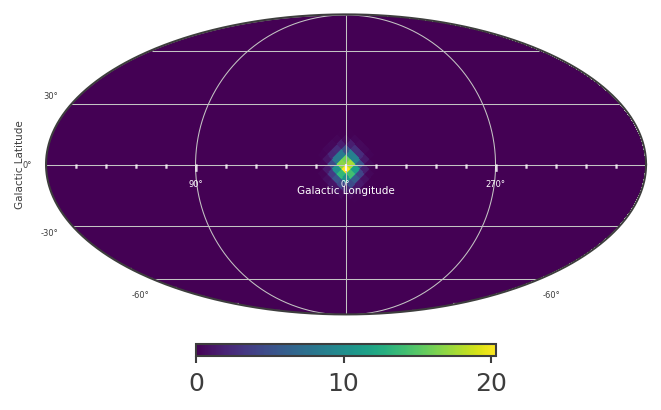

In [4]:
# Plot healpix map:
plot, ax = skymap1.plot(ax_kw = {'coord':'G'})
ax.grid()
lon = ax.coords['glon']
lat = ax.coords['glat']
lon.set_axislabel('Galactic Longitude',color='white',fontsize=5)
lat.set_axislabel('Galactic Latitude',fontsize=5)
lon.display_minor_ticks(True)
lat.display_minor_ticks(True)
lon.set_ticks_visible(True)
lon.set_ticklabel_visible(True)
lon.set_ticks(color='white',alpha=0.6)
lat.set_ticks(color='white',alpha=0.6)
lon.set_ticklabel(color='white',fontsize=4)
lat.set_ticklabel(fontsize=4)
lat.set_ticks_visible(True)
lat.set_ticklabel_visible(True)

Text(0.5, 0, 'Energy [keV]')

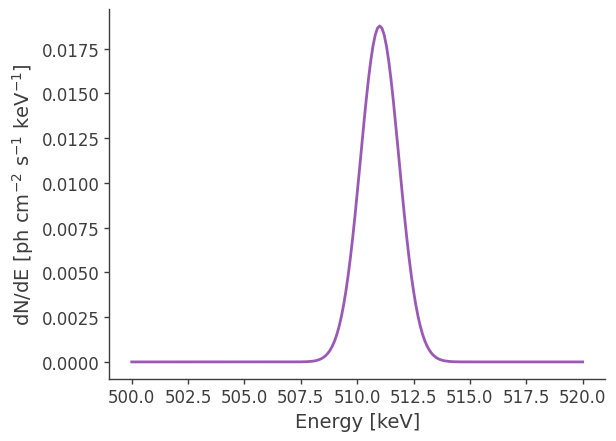

In [5]:
# Plot spectrum:
energy = np.linspace(500.,520.,201)*u.keV
dnde = src1.spectrum.main.Gaussian(energy)
plt.plot(energy, dnde)
plt.ylabel("dN/dE [$\mathrm{ph \ cm^{-2} \ s^{-1} \ keV^{-1}}$]", fontsize=14)
plt.xlabel("Energy [keV]", fontsize=14)

## Load Response

In [6]:
response_file = "SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5"
response = FullDetectorResponse.open(response_file)

## Make Sky Grid
Grid the sky in Galactic coordinates, using the same nside as the response:

In [7]:
nside = response.nside # same as detector response
gal_grid = HealpixBase(nside = nside, coordsys = 'galactic')
gal_coords = gal_grid.pix2skycoord(range(gal_grid.npix))
print("Approximate resolution at NSIDE {} is {:.2} deg".format(nside, hp.nside2resol(nside, arcmin=True) / 60))
print("Number of bins: " + str(len(gal_coords)))
print(gal_coords)

Approximate resolution at NSIDE 16 is 3.7 deg
Number of bins: 3072
<SkyCoord (Galactic): (l, b) in deg
    [( 45.,  87.07581964), (135.,  87.07581964), (225.,  87.07581964), ...,
     (135., -87.07581964), (225., -87.07581964), (315., -87.07581964)]>


Select which pixels to sum in the response calculation. <br>
Note: This step is not needed if you want to use the entire sky.

In [8]:
# Query disk around Galactic center:
l = np.deg2rad(0)
b = np.deg2rad(0)
radius = np.deg2rad(7)
this_pix = gal_grid.ang2pix(l,b,lonlat=True)
vec = gal_grid.pix2vec(this_pix)
grid = gal_grid.query_disc(vec, radius)
print("pixel grid: " + str(grid))
print(gal_coords[grid])

pixel grid: [1312 1376 1439 1440 1441 1503 1504 1567 1568]
<SkyCoord (Galactic): (l, b) in deg
    [(  0.    ,  7.18075578), (  2.8125,  4.78019185),
     (357.1875,  4.78019185), (  0.    ,  2.38801546),
     (  5.625 ,  2.38801546), (354.375 ,  2.38801546),
     (  2.8125,  0.        ), (357.1875,  0.        ),
     (  0.    , -2.38801546)]>


## Get point source response in Galactic coordinates
We will get the point source response in Galactic coordinates.<br>
See detector response tutorial for more details.<br>
Warning: This can take a while, depending on how many points you use. <br>
Note: This step can be skipped if you already have the detector response in Galactic coordinates (recommended). <br>

In [9]:
# Get pointing information:
ori = SpacecraftFile.parse_from_file("20280301_3_month.ori")

# calculate scatt map:
scatt_map = ori.get_scatt_map(nside = response.nside * 2, coordsys = 'galactic')


WARNING ErfaWarning: ERFA function "utctai" yielded 7979956 of "dubious year (Note 3)"



In [10]:
# Calculate the point source response for all passed coordinates
# Note: If using the entire sky, then remove the grid indices in gal_coords. 
start = time.time()
grid_response = response.get_point_source_response(coord = gal_coords[grid], scatt_map = scatt_map)
stop = time.time()
total_time = stop - start
print("processing time [min]: " + str(total_time/60.0))
print(grid_response)

processing time [min]: 20.744217614332836
(<cosipy.response.PointSourceResponse.PointSourceResponse object at 0x1536a6181550>, <cosipy.response.PointSourceResponse.PointSourceResponse object at 0x1536a6181580>, <cosipy.response.PointSourceResponse.PointSourceResponse object at 0x1536a61d1400>, <cosipy.response.PointSourceResponse.PointSourceResponse object at 0x1536a61d1430>, <cosipy.response.PointSourceResponse.PointSourceResponse object at 0x1536a61d1a60>, <cosipy.response.PointSourceResponse.PointSourceResponse object at 0x1536a61d1cd0>, <cosipy.response.PointSourceResponse.PointSourceResponse object at 0x1536a61d1040>, <cosipy.response.PointSourceResponse.PointSourceResponse object at 0x1536a61d1bb0>, <cosipy.response.PointSourceResponse.PointSourceResponse object at 0x1536a61468e0>)


## Get Expectation for Extended Source
We will get the expectation for each point in our sky grid, and add them together to get the expectation for an extended source. <br>
Note: The expectation for a given pixel is based on the same spectrum, but then weighted using the weights from the skymap that we made above. <br>
This step is now done internally within COSILike, but this will show you how it works. <br>
You can skip to the 3ML pugin section if you want. 

In [61]:
# Testing only:
# Use this cell if you are just using 1 pixel. 
# Otherwise, use the cell below. 
this_pix = grid[0]
weight = skymap1[this_pix]*4*np.pi/skymap1.npix 
total_expectation = grid_response.get_expectation(spectrum).project(['Em', 'Phi', 'PsiChi']) * weight
print(total_expectation)
print(type(total_expectation.contents.value) is np.ndarray)

True


In [11]:
# Sum expected counts:
for i in range(0,len(grid_response)):
    
    # Get weight
    this_pix = grid[i]
    weight = skymap1[this_pix]*4*np.pi/skymap1.npix
    
    if i == 0:
        total_expectation = grid_response[i].get_expectation(spectrum).project(['Em', 'Phi', 'PsiChi']) * weight
    if i > 0:
        this_expectation = grid_response[i].get_expectation(spectrum).project(['Em', 'Phi', 'PsiChi']) * weight
        total_expectation += this_expectation

## Make Some Sanity Checks: 
Below you will notice that the expected counts is smaller than the injected counts.<br>
This is because we have only used the extended component. <br>
Later we will see that the model gets scaled up in the likelihood fit. 

In [12]:
# First print a summary of the components:
print("Bin edges: " + str(data_combined.binned_data.axes['Em'].edges))
print("Data counts: " + str(data_combined.binned_data.project('Em').contents.todense()))
print("BG counts: " + str(bg_tot.binned_data.project('Em').contents.todense()))
print("Expected src counts: " + str(total_expectation.project('Em').contents))
print("Injected src counts: " + str(gal_511.binned_data.project('Em').contents.todense()))

Bin edges: [509. 513.] keV
Data counts: [4759387.]
BG counts: [242973.]
Expected src counts: [1784132.22687289] cm2 / cm2
Injected src counts: [4516414.]


Text(0.5, 1.0, 'injected counts')

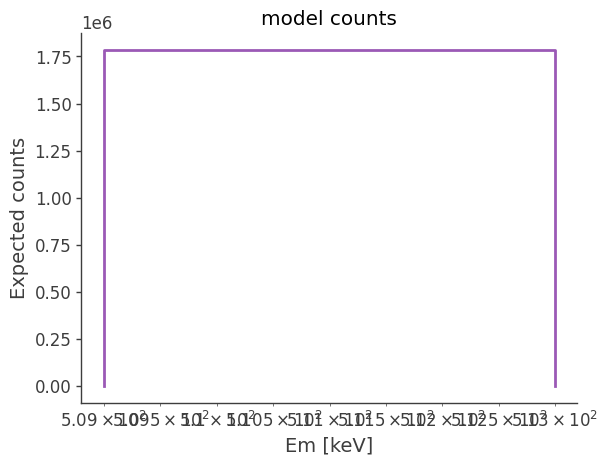

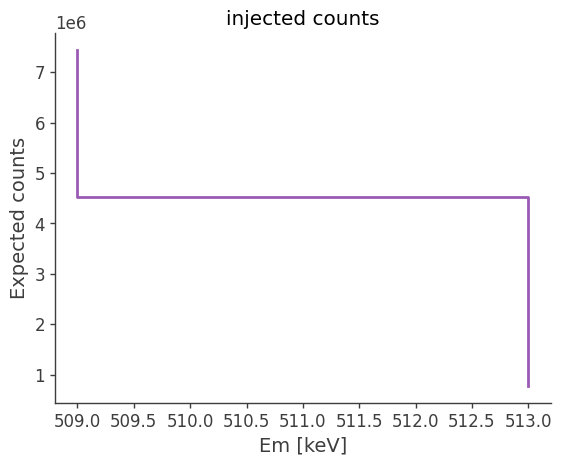

In [13]:
# expected src counts:
ax, plot = total_expectation.project('Em').plot()
ax.set_ylabel('Expected counts')
plt.title("model counts")

# injected src counts:
ax, plot = gal_511.binned_data.project('Em').plot()
ax.set_ylabel('Expected counts')
plt.title("injected counts")

Now let's look at a slice in the CDS projected onto the PsiChi dimension. <br>
You'll notice that compared to the Compton ring of a point source,<br>
the ring of the extended source is wider and more blurred out.

Text(0.5, 1.0, 'injected counts')

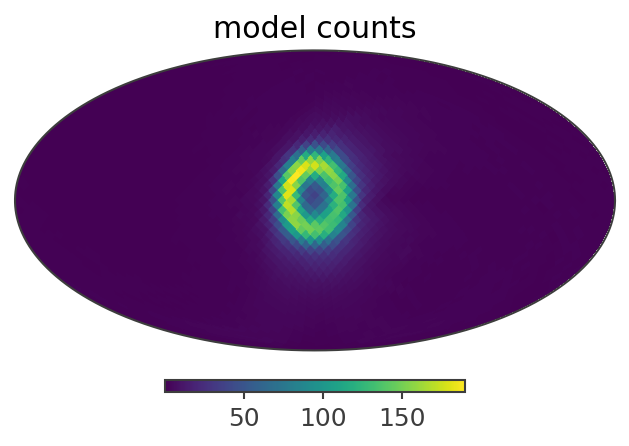

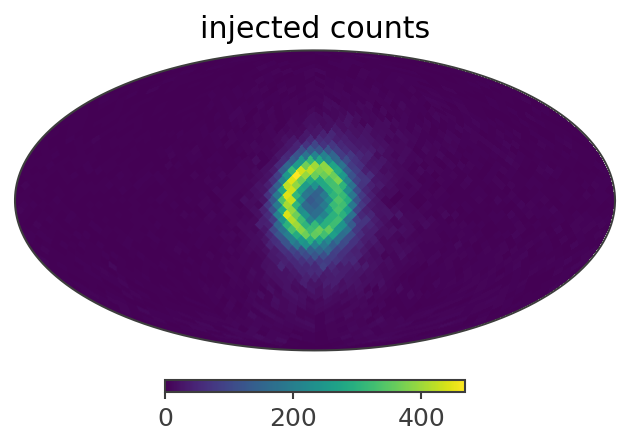

In [14]:
# expected src counts:
ax,plot = total_expectation.slice[{'Em':0, 'Phi':5}].project('PsiChi').plot(ax_kw = {'coord':'G'})
plt.title("model counts")

# injected src counts:
ax,plot = gal_511.binned_data.slice[{'Em':0, 'Phi':5}].project('PsiChi').plot(ax_kw = {'coord':'G'})
plt.title("injected counts")

# uncomment below if you want to make some overlays:
#coord = SkyCoord(0*u.deg,0*u.deg,frame="galactic")
#ax.scatter([coord.l.deg], [coord.b.deg], transform = ax.get_transform('world'), marker = 'o', color = 'red')

## Setup the COSI 3ML plugin and Perform the Likelihood Fit

In [15]:
# Set background parameter, which is used to fit the amplitude of the background:
bkg_par = Parameter("background_cosi",                                        # background parameter
                    1e-4,                                                   # initial value of parameter
                    min_value=0,                                              # minimum value of parameter
                    max_value=5,                                              # maximum value of parameter
                    delta=0.05,                                               # initial step used by fitting engine
                    desc="Background parameter for cosi")

# Instantiate the COSI 3ML plugin
cosi = COSILike("cosi",                                                       # COSI 3ML plugin
                dr = response_file,                                           # detector response
                data = data_combined.binned_data.project('Em', 'Phi', 'PsiChi'),       # data (source+background)
                bkg = bg_tot.binned_data.project('Em', 'Phi', 'PsiChi'),          # background model 
                sc_orientation = ori,                                         # spacecraft orientation
                nuisance_param = bkg_par)                                     # background parameter

# Add sources to model:
model = Model(src1)  # Model with single source. If we had multiple sources, we would do Model(source1, source2, ...)

Quick work around to be used in the set_model method (need to move to source code):

In [16]:
cosi.grid_response = grid_response
cosi.grid = grid
cosi.skymap1 = skymap1

Perform likelihood fit:

In [17]:
plugins = DataList(cosi) # If we had multiple instruments, we would do e.g. DataList(cosi, lat, hawc, ...)

like = JointLikelihood(model, plugins, verbose = False)

like.fit()

00:02:36 INFO      set the minimizer to minuit                                             ]8;id=474842;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=720987;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1042\1042]8;;\


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: invalid value encountered in multiply


WARNING RuntimeWarning: divide by zero encountered in log


WARN

00:02:55 WARNING   get_number_of_data_points not implemented, values for statistical        ]8;id=821237;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/plugin_prototype.py\plugin_prototype.py]8;;\:]8;id=810880;file:///zfs/astrohe/Software/COSIMain_u2/lib/python3.9/site-packages/threeML/plugin_prototype.py#128\128]8;;\
                  measurements such as AIC or BIC are unreliable                                                   

Best fit values:

,result,unit
parameter,,
gaussian.spectrum.main.Gaussian.F,(1.003 +/- 0.007) x 10^-1,1 / (cm2 s)
gaussian.spectrum.main.Gaussian.mu,(5.110 +/- 0.007) x 10^2,keV
background_cosi,1.168 +/- 0.005,


Correlation matrix:

1.00,1.00,-0.00
1.00,1.00,0.03
-0.00,0.03,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-15217542.02313075
total,-15217542.02313075


Values of statistical measures:

,statistical measures
AIC,-30435086.0462615
BIC,-30435084.0462615


(                                         value  negative_error  \
 gaussian.spectrum.main.Gaussian.F     0.100343       -0.000721   
 gaussian.spectrum.main.Gaussian.mu  511.000000       -0.666404   
 background_cosi                       1.167926       -0.004953   
 
                                     positive_error     error         unit  
 gaussian.spectrum.main.Gaussian.F         0.000716  0.000718  1 / (cm2 s)  
 gaussian.spectrum.main.Gaussian.mu        0.663656  0.665030          keV  
 background_cosi                           0.005047  0.005000               ,
          -log(likelihood)
 cosi   -15217542.02313075
 total  -15217542.02313075)

## Results
First, let's just print the results. <br>
Notice that the normalization is 2.5X higher than the injected spectrum. <br>
This is because we fit the data with only a single component. 

In [18]:
results = like.results
results.display()

# Print a summary of the optimized model:
print(results.optimized_model["gaussian"])

Best fit values:

,result,unit
parameter,,
gaussian.spectrum.main.Gaussian.F,(1.003 +/- 0.007) x 10^-1,1 / (cm2 s)
gaussian.spectrum.main.Gaussian.mu,(5.110 +/- 0.007) x 10^2,keV
background_cosi,1.168 +/- 0.005,


Correlation matrix:

1.00,1.00,-0.00
1.00,1.00,0.03
-0.00,0.03,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
cosi,-15217542.02313075
total,-15217542.02313075


Values of statistical measures:

,statistical measures
AIC,-30435086.0462615
BIC,-30435084.0462615


  * gaussian (extended source):
    * shape:
      * lon0:
        * value: 359.75
        * desc: Longitude of the center of the source
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * lat0:
        * value: -1.25
        * desc: Latitude of the center of the source
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * sigma:
        * value: 5.0
        * desc: Standard deviation of the Gaussian distribution
        * min_value: 0.0
        * max_value: 20.0
        * unit: deg
        * is_normalization: false
    * spectrum:
      * main:
        * Gaussian:
          * F:
            * value: 0.1003427609502449
            * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
            * min_value: null
            * max_value: null
            * unit: s-1 cm-2
            * is_normalization: false
          * mu:
         

Now let's make some plots. <br>
Let's first look at the best-fit spectrum:

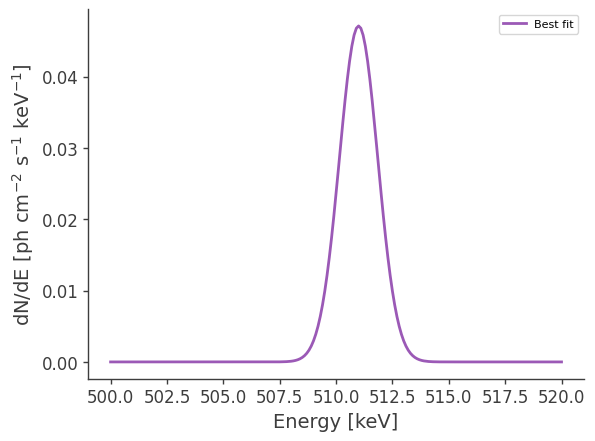

In [19]:
# Best-fit model:
energy = np.linspace(500.,520.,201)*u.keV
flux = results.optimized_model["gaussian"].spectrum.main.shape(energy)

fig,ax = plt.subplots()

ax.plot(energy, flux, label = "Best fit")


plt.ylabel("dN/dE [$\mathrm{ph \ cm^{-2} \ s^{-1} \ keV^{-1}}$]", fontsize=14)
plt.xlabel("Energy [keV]", fontsize=14)
ax.legend()

Now let's convolve the best-fit spectrum with the response, and compare the predicted counts to the injected counts:

Error: [2115.5658436] cm / cm


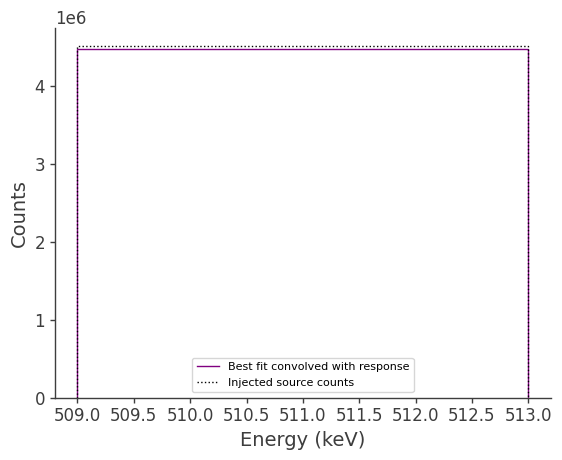

In [20]:
spectrum = results.optimized_model["gaussian"].spectrum.main.shape

# Sum expected counts:
for i in range(0,len(grid_response)):
    
    # Get weight
    this_pix = grid[i]
    weight = skymap1[this_pix]*4*np.pi/skymap1.npix
    
    if i == 0:
        total_expectation = grid_response[i].get_expectation(spectrum).project(['Em', 'Phi', 'PsiChi']) * weight
    if i > 0:
        this_expectation = grid_response[i].get_expectation(spectrum).project(['Em', 'Phi', 'PsiChi']) * weight
        total_expectation += this_expectation
        
# Plot:       
fig,ax = plt.subplots()

binned_energy_edges = gal_511.binned_data.axes['Em'].edges.value
binned_energy = gal_511.binned_data.axes['Em'].centers.value

ax.stairs(total_expectation.project('Em').todense().contents, binned_energy_edges, color='purple', label = "Best fit convolved with response")
ax.errorbar(binned_energy, total_expectation.project('Em').todense().contents, yerr=np.sqrt(total_expectation.project('Em').todense().contents), color='purple', linewidth=0, elinewidth=1)
ax.stairs(gal_511.binned_data.project('Em').todense().contents, binned_energy_edges, color = 'black', ls = ":", label = "Injected source counts")
ax.errorbar(binned_energy, gal_511.binned_data.project('Em').todense().contents, yerr=np.sqrt(gal_511.binned_data.project('Em').todense().contents), color='black', linewidth=0, elinewidth=1)

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Counts")

ax.legend()

# Note: We are plotting the error, but it's very small:
print("Error: " +str(np.sqrt(total_expectation.project('Em').todense().contents)))

Let's also compare the projection onto Psichi:

Text(0.5, 1.0, 'injected counts')

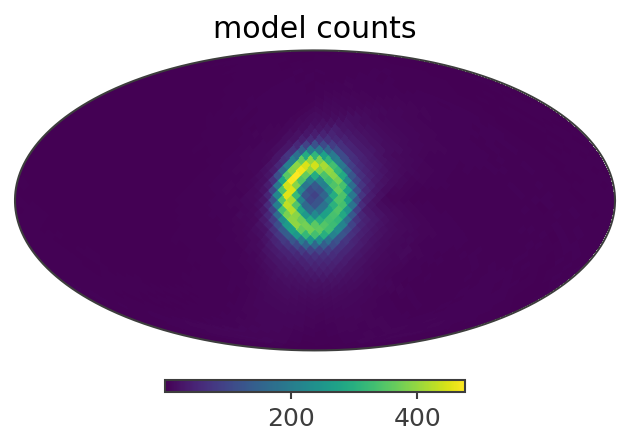

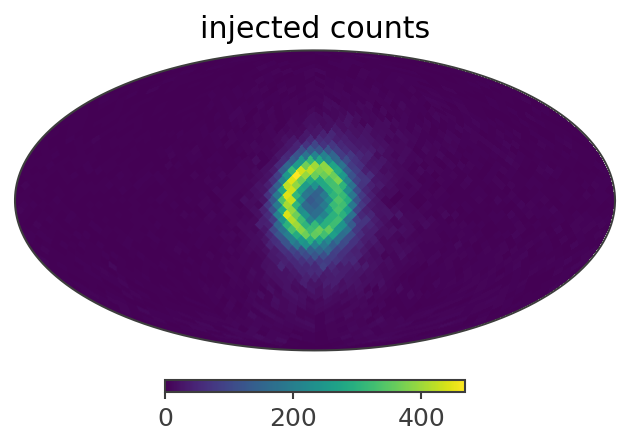

In [21]:
# expected src counts:
ax,plot = total_expectation.slice[{'Em':0, 'Phi':5}].project('PsiChi').plot(ax_kw = {'coord':'G'})
plt.title("model counts")

# injected src counts:
ax,plot = gal_511.binned_data.slice[{'Em':0, 'Phi':5}].project('PsiChi').plot(ax_kw = {'coord':'G'})
plt.title("injected counts")

# **********************************************************
# Stop here! 
# Next part not ready yet. 
# Just need the point source fit in Galactic coordinates.
## Perform Analysis with Two Comptonents
Now, define the point source. <br>
We'll add this to the model, but keep the parameters fixed.

In [13]:
# Note: Astromodels only takes ra,dec for point source input:
c = SkyCoord(l=0*u.deg, b=0*u.deg, frame='galactic')
c_icrs = c.transform_to('icrs')

# Define source:
spectrum2 = Gaussian(F = 4e-2, mu = 511, sigma = 0.85)
src2 = PointSource('point_source', ra = c_icrs.ra.deg, dec = c_icrs.dec.deg, spectral_shape=spectrum2)

# Set spectral parameters for fitting:
spectrum2.F.free = False
spectrum2.mu.free = False
spectrum2.sigma.free = False

# Print some info about the source just as a sanity check.
# This will also show you which parameters are free. 
print(src2.spectrum.main.shape)

# We can also get a summary of the source info as follows:
#src2.display()

  * description: A Gaussian function
  * formula: $ K \frac{1}{\sigma \sqrt{2 \pi}}\exp{\frac{(x-\mu)^2}{2~(\sigma)^2}} $
  * parameters:
    * F:
      * value: 0.04
      * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
      * min_value: null
      * max_value: null
      * unit: s-1 cm-2
      * is_normalization: false
      * delta: 0.1
      * free: false
    * mu:
      * value: 511.0
      * desc: Central value
      * min_value: null
      * max_value: null
      * unit: keV
      * is_normalization: false
      * delta: 0.1
      * free: false
    * sigma:
      * value: 0.85
      * desc: standard deviation
      * min_value: 1.0e-12
      * max_value: null
      * unit: keV
      * is_normalization: false
      * delta: 0.1
      * free: false

